In [ ]:
import pandas as pd
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
from google.colab import drive
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls_result = os.listdir('/content/drive/MyDrive/sign_data')

print(f"Files: {ls_result}")

BASE_PATH = '/content/drive/MyDrive/sign_data'

Files: ['test_data.csv', 'train_data.csv', '.DS_Store', 'train', 'test']


In [ ]:
test_df = pd.read_csv(f'{BASE_PATH}/test_data.csv')
train_df = pd.read_csv(f'{BASE_PATH}/train_data.csv')

In [ ]:
train_df.head()

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [ ]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir

    def shuffle(self):
        return self.dataset.sample(frac=1)

    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8)

        img_cv2 = cv2.Canny(img.numpy(), 20, 220)

        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0

        return img_cv2

    def datagen(self):
        num_samples = len(self.dataset)
        while True:
            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]


                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label

In [ ]:
train_set, val_set = train_test_split(train_df, test_size=0.2)

train_loader = DataLoader(train_set, 256, f'{BASE_PATH}/train')
val_loader = DataLoader(val_set, 256, f'{BASE_PATH}/train')

In [ ]:
train_generator = train_loader.datagen()

train_generator

<generator object DataLoader.datagen at 0x794f1550de00>

In [ ]:
# for i in range (5):
#     batch_data, label = next(train_generator)
#     pair_data = batch_data["image1"], batch_data["image2"]

#     print(f"Pair {i+1}:")
#     print("Label:", label[0])

#     plt.figure(figsize=(10, 5))
#     for j in range(2):
#         plt.subplot(1, 2, j+1)
#         plt.imshow(pair_data[j][0], cmap='gray')
#         plt.title('Image {}'.format(j+1))
#         plt.axis('off')

In [ ]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))

    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    embedding1 = model(input1)
    embedding2 = model(input2)

    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]),
                                      output_shape=(128,))
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])


    output = Dense(1, activation='sigmoid')(manhattan_distance)

    return Model(inputs=[input1, input2], outputs=output)

In [ ]:
input_shape = (128, 128, 1)

In [ ]:
model = create_model(input_shape)
model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer)       │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image2 (InputLayer)       │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │      2,522,624 │ image1[0][0],          │
│                           │                        │                │ image2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            129 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,522,753 (9.62 MB)

 Trainable params: 2,522,753 (9.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Model training
history = model.fit(x=train_loader.datagen(),
                            steps_per_epoch=len(train_set) // 256,
                            epochs=6,
                            validation_data=val_loader.datagen(),
                            validation_steps=len(val_set) // 256,
                            callbacks=callbacks_list)

Epoch 1/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6063 - loss: 0.6500
Epoch 1: val_accuracy improved from -inf to 0.71940, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 731s 10s/step - accuracy: 0.6070 - loss: 0.6496 - val_accuracy: 0.7194 - val_loss: 0.5825
Epoch 2/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7419 - loss: 0.5260
Epoch 2: val_accuracy improved from 0.71940 to 0.82805, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.7423 - loss: 0.5254 - val_accuracy: 0.8281 - val_loss: 0.4089
Epoch 3/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8500 - loss: 0.3449
Epoch 3: val_accuracy improved from 0.82805 to 0.92771, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 369s 5s/step - accuracy: 0.8503 - loss: 0.3445 - val_accuracy: 0.9277 - val_loss: 0.2266
Epoch 4/6
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9216 - loss: 0.2035
Epoch 4: val_accuracy improved from 0.92771 to 0.96100, sav

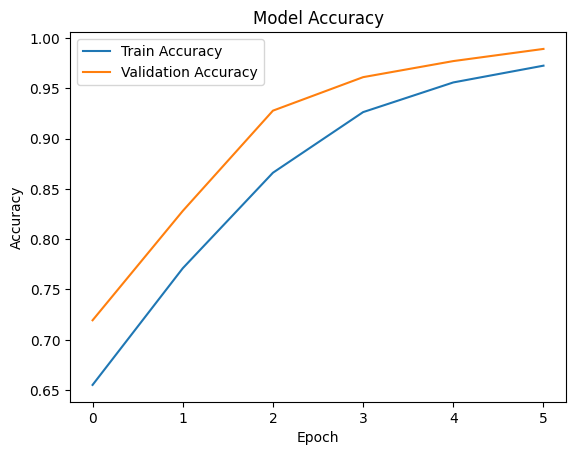

In [ ]:
# Train and val model accuracy per epoch
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

Testing the model

In [ ]:
test_loader = DataLoader(test_df, 256, f'{BASE_PATH}/test')

In [ ]:
test_loss, test_accuracy = model.evaluate(test_loader.datagen(), steps=len(test_df) // 256)


22/22 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.9912 - loss: 0.0386
